In [1]:
import numpy as np
import chainer
from chainer import cuda,  Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain
from chainer import initializers
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
import pickle

%matplotlib inline 

In [2]:
def imshow_mnist(x):
    plt.imshow(np.reshape(x,[28,28]))
    plt.gray()

def imshow_multi(x,c=5,r=5):
    fig=plt.figure(figsize=[15,15])
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        plt.imshow(np.reshape(x[i,:],[28,28]))
        plt.tick_params(labelbottom='off')
        plt.tick_params(labelleft='off')

In [3]:
mnist = fetch_mldata('MNIST original')
mnist.data   = mnist.data.astype(np.float32)
mnist.data  /= 255     # 0-1のデータに変換


In [4]:
x_train = mnist.data
x_train = x_train.reshape(x_train.shape[0],1,28,28)
labels = mnist.target
n_label = len(np.unique(labels))
img_shape = x_train[0,0].shape
del mnist

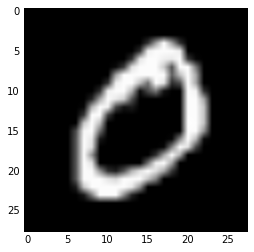

In [5]:
imshow_mnist(x_train[0,:])

In [9]:
class Generator(chainer.Chain):
    def __init__(self,z_dim):
        w = initializers.Normal(0.2)
        super(Generator, self).__init__(
            
            l1=L.Linear(z_dim + n_label,512*3*3,initialW=w),
            dcv1=L.Deconvolution2D(in_channels=512,out_channels=256,ksize=2,stride=2,pad=1,initialW=w),
            dcv2=L.Deconvolution2D(in_channels=256,out_channels=128,ksize=2,stride=2,pad=1,initialW=w),
            dcv3=L.Deconvolution2D(in_channels=128,out_channels=64,ksize=2,stride=2,pad=1,initialW=w),
            dcv4=L.Deconvolution2D(in_channels=64,out_channels=1,ksize=3,stride=3,pad=1,initialW=w),
            bn1=L.BatchNormalization(size=512),
            bn2=L.BatchNormalization(size=256),
            bn3=L.BatchNormalization(size=128),
            bn4=L.BatchNormalization(size=64),
        )
    def __call__(self,z,train=True):
        x = F.reshape(self.l1(z),(z.data.shape[0],512,3,3))
        x=self.dcv1(F.leaky_relu(self.bn1(x)))
        x=self.dcv2(F.leaky_relu(self.bn2(x)))
        x=self.dcv3(F.leaky_relu(self.bn3(x)))
        x=self.dcv4(F.leaky_relu(self.bn4(x)))
        return F.sigmoid(x)
    

In [10]:
class Discriminator(chainer.Chain):
    def __init__(self):
        w = initializers.Normal(0.2)
        super(Discriminator,self).__init__(
            
            conv1=L.Convolution2D(in_channels=1 + n_label,out_channels=64,ksize=3,stride=3,pad=1,initialW=w),
            conv2=L.Convolution2D(in_channels=64,out_channels=128,ksize=2,stride=2,pad=1,initialW=w),
            conv3=L.Convolution2D(in_channels=128,out_channels=256,ksize=2,stride=2,pad=1,initialW=w),
            conv4=L.Convolution2D(in_channels=256,out_channels=512,ksize=2,stride=2,pad=1,initialW=w),
            
            bc1=L.BatchNormalization(size=128,use_gamma=False),
            bc2=L.BatchNormalization(size=256,use_gamma=False),
            bc3=L.BatchNormalization(size=512,use_gamma=False),
            fc=L.Linear(3*3*512,2,initialW=w)
        )
    def __call__(self,x,train=True):
        h=F.leaky_relu((self.conv1(x)))
        h=F.leaky_relu(self.bc1(self.conv2(h)))
        h=F.leaky_relu(self.bc2(self.conv3(h)))
        h=F.leaky_relu(self.bc3(self.conv4(h)))
        #h=F.reshape(h,[x.data.shape[0],32])
        h=self.fc(h)
        
        return h
        


In [11]:
import os
if not os.path.exists('model'):
    os.mkdir('model')

In [12]:
def var_float(x):
    return Variable(cuda.to_gpu(x.astype(np.float32)))
    
def var_int(x):
    return Variable(cuda.to_gpu(x.astype(np.int32)))
    

In [13]:
z_dim = 100
G=Generator(z_dim)
D=Discriminator()

G.to_gpu()
D.to_gpu()

In [14]:

opt_g = optimizers.Adam(alpha=0.0002, beta1=0.5)
opt_d = optimizers.Adam(alpha=0.0002, beta1=0.5)
opt_g.setup(G)
opt_d.setup(D)
opt_g.add_hook(chainer.optimizer.WeightDecay(0.0001))
opt_d.add_hook(chainer.optimizer.WeightDecay(0.0001))


In [15]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(labels.reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [16]:
def label_to_img(label):
    temp = np.expand_dims(np.expand_dims(label_ohe,axis=2),axis=3)
    label_img = np.repeat(np.repeat(temp,img_shape[0],axis=2),img_shape[1],axis=3)
    return label_img

In [20]:

bs=1000
ones = var_int(np.ones(bs))
zeros = var_int(np.zeros(bs))
lossG_hist=[]
lossD_hist=[]
for i in range(20000):
    if np.mod(i,10)==0:
        print i
    r=np.random.permutation(len(x_train))
    x=x_train[r[0:bs],:]
    label = labels[r[0:bs]]
    label_ohe = ohe.transform(label.reshape(-1,1)).toarray()
    label_img = label_to_img(label)
    x_label = np.concatenate([x,label_img],axis=1)
    x_label = var_float(x_label)
    
    z = np.random.uniform(low=-1,high=1,size=[bs,z_dim])    
    z_label = np.concatenate([z,label_ohe],axis=1)
    z_label = var_float(z_label)
    
    resG=G(z_label)
    resD=D(x_label)
    resG_label = F.concat([resG,var_float(label_img)],axis=1)
    resD_from_G=D(resG_label)

    lossD = F.softmax_cross_entropy(resD,ones) + F.softmax_cross_entropy(resD_from_G,zeros)
    lossG = F.softmax_cross_entropy(resD_from_G,ones)
        
    #opt_d.zero_grads()
    D.cleargrads()
    lossD.backward()
    opt_d.update()
    
    #opt_g.zero_grads()
    G.cleargrads()
    lossG.backward()
    opt_g.update()
    
    lossG_hist.append(lossG.data)
    lossD_hist.append(lossD.data)
        
    if np.mod(i,100) == 0:
        
        with open('./model/G{}'.format(i),'wb') as f:
            pickle.dump(G,f)
        with open('./model/D{}'.format(i),'wb') as f:
            pickle.dump(D,f)
            
#     print('----')
#     print(lossG.data)
#     print(lossD.data)
# plt.subplot(1,2,1)
# plt.plot(lossG_hist)
# plt.subplot(1,2,2)
# plt.plot(lossD_hist)

0


KeyboardInterrupt: 

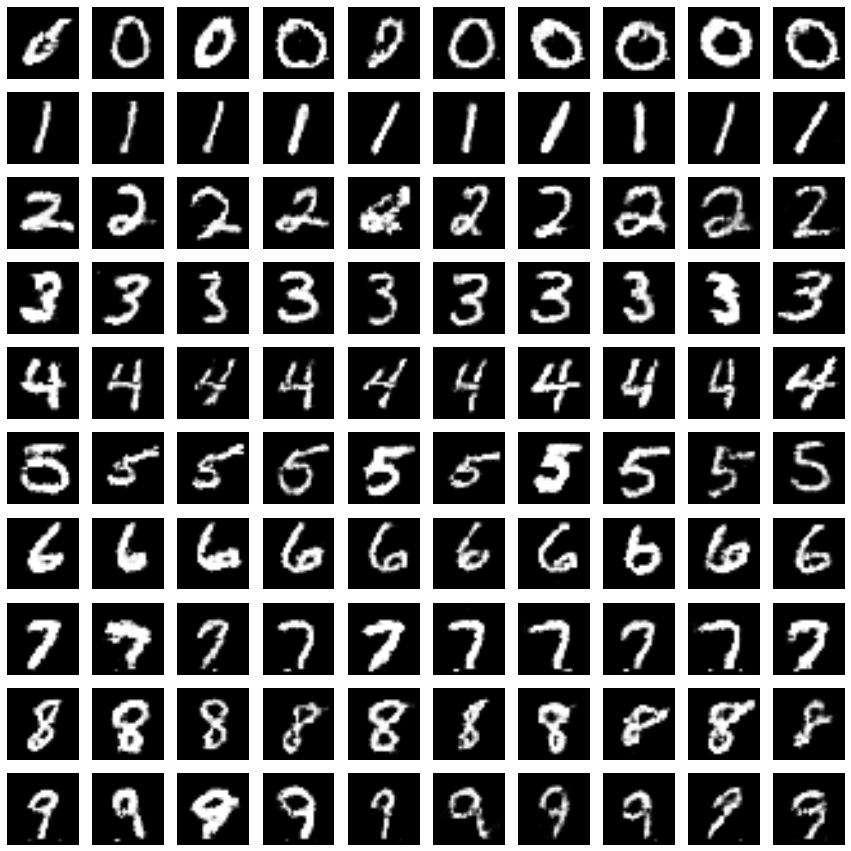

In [80]:
#conditional generation
label = np.array([[k]*10 for k in range(10)]).flatten()
label_ohe = ohe.transform(label.reshape(-1,1)).toarray()
z = np.random.uniform(low=-1,high=1,size=[100,z_dim])    
z_label = np.concatenate([z,label_ohe],axis=1)

resG = G(var_float(z_label))
img = cuda.to_cpu(resG.data)
imshow_multi(img,10,10)
plt.savefig('conditional_dcgan_generation')

In [81]:

def linear_interpolation(base,target,n_step):
    d = target - base
    step = d/(n_step - 1)

    z_list = []
    for k in range(n_step):
        z_list.append(base + step * k)
    z_list = np.vstack(z_list)
    return z_list

In [ ]:
#linear interpolation
#z
label = np.array([[k]*1 for k in range(10)]).flatten()
label_ohe = ohe.transform(label.reshape(-1,1)).toarray()
z = np.random.uniform(low=-0.01,high=0.01,size=[10,z_dim]) 
z_label = np.concatenate([z,label_ohe],axis=1)

#interpolation
z_list = []
n_interpolation = 10
for k in range(10):
    if k<9:
        temp = linear_interpolation(z_label[k],z_label[k+1],n_interpolation)
    if k==9:
        temp = linear_interpolation(z_label[9],z_label[0],n_interpolation)
    z_list.append(temp)

z_list = np.vstack(z_list)
img = cuda.to_cpu(G(var_float(z_list)).data)

imshow_multi(img,10,10)
plt.savefig('conditional_dcgan_interpolation')